In [26]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

In [27]:
df = pd.read_csv('celeb_attr.csv', index_col=False)
df = df.replace(-1, 0)

In [28]:
class CelebrityImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        img_path = f"{self.img_dir}/{self.dataframe.iloc[idx]['Image_Name']}"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        labels = torch.tensor(self.dataframe.iloc[idx][1:].values.astype('float32'))

        return image, labels

In [29]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [30]:
from torch.utils.data import DataLoader

In [114]:
import torch.nn as nn
import torch.nn.functional as F

class AttributeCNN(nn.Module):
    def __init__(self, num_classes=40):
        super(AttributeCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.relu3 = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128*16*16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        x = self.relu3(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x




In [74]:
import torch.optim as optim

device= torch.device("cuda")

model = AttributeCNN(num_classes=40)
model.to(device)

evaluator = nn.BCELoss()
optimizer= optim.Adam(model.parameters(), lr=0.001)

In [32]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = CelebrityImageDataset(train_df, img_dir='datasets/celeba/img_celeba/img_celeba', transform=transform)
test_dataset = CelebrityImageDataset(test_df, img_dir='datasets/celeba/img_celeba/img_celeba', transform=transform)

In [33]:
train_loading = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loading = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [14]:
epochs = 10
from tqdm import tqdm

for epoch in range(epochs):
    model.train()
    total_loss= 0.0

    loop = tqdm(train_loading, desc=f"Epoch [{epoch+1}/{epochs}]")
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images) #forward pass
        loss = evaluator(outputs, labels)
        optimizer.zero_grad() #Zero Gradient
        loss.backward() # Backprop

        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss/len(train_loading)
    print(f"Epoch {epoch+1}, Loss {avg_loss:.4f}")

Epoch [1/10]: 100%|██████████| 5065/5065 [01:48<00:00, 46.65it/s, loss=0.32] 


Epoch 1, Loss 0.2974


Epoch [2/10]: 100%|██████████| 5065/5065 [01:47<00:00, 47.10it/s, loss=0.287]


Epoch 2, Loss 0.2874


Epoch [3/10]: 100%|██████████| 5065/5065 [01:46<00:00, 47.73it/s, loss=0.297]


Epoch 3, Loss 0.2795


Epoch [4/10]: 100%|██████████| 5065/5065 [01:44<00:00, 48.56it/s, loss=0.257]


Epoch 4, Loss 0.2724


Epoch [5/10]: 100%|██████████| 5065/5065 [01:45<00:00, 47.84it/s, loss=0.255]


Epoch 5, Loss 0.2662


Epoch [6/10]: 100%|██████████| 5065/5065 [01:45<00:00, 47.80it/s, loss=0.268]


Epoch 6, Loss 0.2604


Epoch [7/10]: 100%|██████████| 5065/5065 [01:44<00:00, 48.56it/s, loss=0.257]


Epoch 7, Loss 0.2554


Epoch [8/10]: 100%|██████████| 5065/5065 [01:43<00:00, 48.77it/s, loss=0.246]


Epoch 8, Loss 0.2508


Epoch [9/10]: 100%|██████████| 5065/5065 [01:44<00:00, 48.61it/s, loss=0.234]


Epoch 9, Loss 0.2464


Epoch [10/10]: 100%|██████████| 5065/5065 [01:43<00:00, 48.80it/s, loss=0.237]

Epoch 10, Loss 0.2424


In [ ]:
from torchvision import transforms
from PIL import Image

model = AttributeCNN()
model.load_state_dict(torch.load('models/Model1.pth', weights_only=True))
model.eval()


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

image = Image.open('image.jpg').convert("RGB")

image_tensor = transform(image).unsqueeze(0)


model.eval()
model.to(device)
image_tensor = image_tensor.to(device)

with torch.no_grad():
    output = model(image_tensor)


    preds = (output > 0.5).int() 

preds

tensor([[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]], device='cuda:0',
       dtype=torch.int32)

In [21]:
torch.save(model.state_dict(), "models/Model1.pth")

In [24]:

from sklearn.metrics import classification_report
all_predict = []
all_targets = []
model.eval()

with torch.no_grad():
    loop = tqdm(test_loading)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images)
        preds = (outputs > 0.5).float()
        all_predict.append(preds.cpu())
        all_targets.append(labels.cpu())
    
all_predict = torch.cat(all_predict, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

100%|██████████| 1267/1267 [00:26<00:00, 48.60it/s]


In [59]:
report=classification_report(all_targets, all_predict, output_dict=True)
print(report)

{'0': {'precision': 0.6523364485981309, 'recall': 0.2341757995974055, 'f1-score': 0.3446346280447663, 'support': 4471.0}, '1': {'precision': 0.6084782090974041, 'recall': 0.4721862871927555, 'f1-score': 0.5317377731529657, 'support': 10822.0}, '2': {'precision': 0.7814687087939953, 'recall': 0.744324219882137, 'f1-score': 0.7624443344878773, 'support': 20702.0}, '3': {'precision': 0.5866369710467706, 'recall': 0.1571974218190499, 'f1-score': 0.24795255577520475, 'support': 8378.0}, '4': {'precision': 0.6938775510204082, 'recall': 0.33663366336633666, 'f1-score': 0.4533333333333333, 'support': 909.0}, '5': {'precision': 0.7675753228120517, 'recall': 0.5130254115390762, 'f1-score': 0.6150014369192451, 'support': 6257.0}, '6': {'precision': 0.5695674830640959, 'recall': 0.11161033391197794, 'f1-score': 0.18664617486338797, 'support': 9793.0}, '7': {'precision': 0.6518501279962765, 'recall': 0.29283847360167276, 'f1-score': 0.4041263886885009, 'support': 9565.0}, '8': {'precision': 0.73680

In [60]:
classification_df = pd.DataFrame(report).transpose()


In [74]:
individual_stats = classification_df[:-4].set_index(df.columns[1:])
summary_stats = classification_df.iloc[-4:]

In [77]:
individual_stats.to_csv("individual_stats1.csv")
summary_stats.to_csv("summary_stats1.csv")

In [26]:
df.sum()

Image_Name             000001.jpg000002.jpg000003.jpg000004.jpg000005...
5_o_Clock_Shadow                                                   22516
Arched_Eyebrows                                                    54090
Attractive                                                        103833
Bags_Under_Eyes                                                    41446
Bald                                                                4547
Bangs                                                              30709
Big_Lips                                                           48785
Big_Nose                                                           47516
Black_Hair                                                         48472
Blond_Hair                                                         29983
Blurry                                                             10312
Brown_Hair                                                         41572
Bushy_Eyebrows                                     

In [118]:
device= torch.device("cuda")

model = AttributeCNN(num_classes=40)
model.to(device)

optimizer= optim.Adam(model.parameters(), lr=0.001)

In [119]:
positive_counts = df.iloc[:, 1:].sum(axis=0).values
negative_counts = len(df) - positive_counts

pos_weight = negative_counts / (positive_counts)

In [120]:
pos_weight

array([ 7.99800142,  2.74559068,  0.95120049,  3.88826425, 43.55663075,
        5.59738188,  3.15289536,  3.26380588,  3.179712  ,  5.75712904,
       18.64691621,  3.87344847,  6.0339548 , 16.37108806, 20.41864891,
       14.35655272, 14.93260459, 22.83798094,  1.58450057,  1.19764831,
        1.39949546,  1.06856099, 23.07021504,  7.68442711,  0.19769092,
        2.51936005, 22.28456499,  2.60432307, 11.53473984, 14.21584679,
       16.69578129,  1.07434293,  3.79842262,  2.12923205,  4.29310795,
       19.63546547,  1.11669017,  7.13226027, 12.7523079 ,  0.29262955])

In [121]:
df.sum()

Image_Name             000001.jpg000002.jpg000003.jpg000004.jpg000005...
5_o_Clock_Shadow                                                   22516
Arched_Eyebrows                                                    54090
Attractive                                                        103833
Bags_Under_Eyes                                                    41446
Bald                                                                4547
Bangs                                                              30709
Big_Lips                                                           48785
Big_Nose                                                           47516
Black_Hair                                                         48472
Blond_Hair                                                         29983
Blurry                                                             10312
Brown_Hair                                                         41572
Bushy_Eyebrows                                     

In [122]:
positive_counts = df.iloc[:, 1:].sum(axis=0).values 
negative_counts = len(df) - positive_counts
pos_weight = negative_counts / (positive_counts)

pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

In [127]:
evaluator = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

In [128]:
optimizer= optim.Adam(model.parameters(), lr=0.1e-4)

In [129]:
epochs = 10
from tqdm import tqdm

for epoch in range(epochs):
    model.train()
    total_loss= 0.0

    loop = tqdm(train_loading, desc=f"Epoch [{epoch+1}/{epochs}]")
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()
        outputs = model(images) #forward pass
        loss = evaluator(outputs, labels)
        #loss = sigmoid_focal_loss(
            #inputs=outputs,   
            #targets=labels,       
            #alpha=0.25,           
            #gamma=2.0,            
            #reduction="mean"      
        #)
        optimizer.zero_grad() #Zero Gradient
        loss.backward() # Backprop

        optimizer.step()
        
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss/len(train_loading)
    print(f"Epoch {epoch+1}, Loss {avg_loss:.4f}")

Epoch [1/10]: 100%|██████████| 5065/5065 [01:47<00:00, 47.07it/s, loss=0.888] 


Epoch 1, Loss 1.0214


Epoch [2/10]: 100%|██████████| 5065/5065 [01:48<00:00, 46.66it/s, loss=0.865] 


Epoch 2, Loss 0.9489


Epoch [3/10]: 100%|██████████| 5065/5065 [01:47<00:00, 47.19it/s, loss=1.01]  


Epoch 3, Loss 0.9234


Epoch [4/10]: 100%|██████████| 5065/5065 [01:47<00:00, 47.23it/s, loss=0.874] 


Epoch 4, Loss 0.9054


Epoch [5/10]: 100%|██████████| 5065/5065 [01:46<00:00, 47.38it/s, loss=0.921] 


Epoch 5, Loss 0.8901


Epoch [6/10]: 100%|██████████| 5065/5065 [01:45<00:00, 47.93it/s, loss=0.767] 


Epoch 6, Loss 0.8774


Epoch [7/10]: 100%|██████████| 5065/5065 [01:46<00:00, 47.40it/s, loss=0.846] 


Epoch 7, Loss 0.8665


Epoch [8/10]: 100%|██████████| 5065/5065 [01:47<00:00, 46.97it/s, loss=0.743] 


Epoch 8, Loss 0.8569


Epoch [9/10]: 100%|██████████| 5065/5065 [01:44<00:00, 48.33it/s, loss=0.782] 


Epoch 9, Loss 0.8486


Epoch [10/10]: 100%|██████████| 5065/5065 [01:47<00:00, 47.19it/s, loss=0.725] 

Epoch 10, Loss 0.8407


In [130]:
torch.save(model.state_dict(), "models/Model2.pth")

In [131]:

from sklearn.metrics import classification_report
all_predict = []
all_targets = []
model.eval()

with torch.no_grad():
    loop = tqdm(test_loading)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images)
        preds = (outputs > 0.5).int()
        
        all_predict.append(preds.cpu())
        all_targets.append(labels.cpu())
    
all_predict = torch.cat(all_predict, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

100%|██████████| 1267/1267 [00:28<00:00, 43.85it/s]


In [132]:
report=classification_report(all_targets, all_predict, output_dict=False, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.31      0.52      0.38      4471
           1       0.49      0.43      0.46     10822
           2       0.77      0.53      0.63     20702
           3       0.42      0.32      0.36      8378
           4       0.22      0.76      0.34       909
           5       0.45      0.45      0.45      6257
           6       0.40      0.14      0.20      9793
           7       0.51      0.37      0.42      9565
           8       0.57      0.64      0.60      9649
           9       0.54      0.82      0.65      6023
          10       0.15      0.46      0.23      1953
          11       0.54      0.49      0.51      8465
          12       0.32      0.42      0.37      5775
          13       0.23      0.51      0.31      2331
          14       0.21      0.54      0.30      1895
          15       0.21      0.51      0.30      2588
          16       0.19      0.50      0.28      2536
          17       0.30    

In [136]:
from sklearn.metrics import classification_report
all_probabilities = []
all_targets = []
model.eval()

with torch.no_grad():
    loop = tqdm(test_loading)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)

        all_probabilities.append(probabilities.cpu())
        all_targets.append(labels.cpu())
    
all_predict = torch.cat(all_probabilities, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

100%|██████████| 1267/1267 [00:27<00:00, 46.06it/s]


In [137]:
from sklearn.metrics import precision_recall_curve
import numpy as np
def compute_optimal_thresholds(y_true, y_probs):
    thresholds = []
    for i in range(y_true.shape[1]):
        precision, recall, threshold = precision_recall_curve(y_true[:, i], y_probs[:, i])
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        acceptable_precision = precision>=0.6
        if np.any(acceptable_precision):
            best_filtered_f1 = np.argmax(f1 * acceptable_precision)
            best_thresh = threshold[best_filtered_f1]
        else:
            best_thresh=0.5
        thresholds.append(best_thresh)
    return np.array(thresholds)

In [138]:
optimal_thresholds = compute_optimal_thresholds(all_targets, all_predict) #Classes

In [139]:
optimal_thresholds

array([0.93466073, 0.811106  , 0.39856088, 0.85613024, 0.96880686,
       0.7098795 , 0.05452893, 0.7136045 , 0.6562842 , 0.7425398 ,
       0.00907336, 0.68065137, 0.8324899 , 0.97372353, 0.97615325,
       0.9002332 , 0.91283226, 0.91144353, 0.48348433, 0.4934527 ,
       0.4224365 , 0.54715914, 0.92128587, 0.2835773 , 0.15732786,
       0.6802092 , 0.96943563, 0.08479413, 0.9462624 , 0.96976984,
       0.9228611 , 0.47901064, 0.83943474, 0.64706415, 0.8877636 ,
       0.86872035, 0.453156  , 0.00579376, 0.7985799 , 0.2360897 ],
      dtype=float32)

In [140]:
all_predict = []
all_targets = []
model.eval()

thresholds = torch.tensor(optimal_thresholds).to(device)

with torch.no_grad():
    loop = tqdm(test_loading)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)

        predictions = (probabilities > thresholds.unsqueeze(0)).float()

        all_predict.append(predictions.cpu())
        all_targets.append(labels.cpu())
    
all_predict = torch.cat(all_predict, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

100%|██████████| 1267/1267 [00:25<00:00, 49.14it/s]


In [141]:
report=classification_report(all_targets, all_predict, output_dict=False)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.01      0.01      4471
           1       0.60      0.05      0.09     10822
           2       0.64      0.87      0.74     20702
           3       0.59      0.01      0.01      8378
           4       0.60      0.17      0.26       909
           5       0.60      0.23      0.34      6257
           6       0.24      1.00      0.39      9793
           7       0.60      0.20      0.29      9565
           8       0.60      0.58      0.59      9649
           9       0.64      0.73      0.68      6023
          10       0.05      1.00      0.09      1953
          11       0.60      0.37      0.46      8465
          12       0.60      0.04      0.08      5775
          13       0.56      0.00      0.00      2331
          14       0.59      0.01      0.01      1895
          15       0.60      0.04      0.08      2588
          16       0.61      0.01      0.01      2536
          17       0.60    

In [8]:
report2 = pd.read_csv("individual_stats1.csv")

In [142]:

model = AttributeCNN(num_classes=40)
model.to(device)

optimizer= optim.Adam(model.parameters(), lr=0.001)

In [143]:
epochs = 10
from tqdm import tqdm

for epoch in range(epochs):
    model.train()
    total_loss= 0.0

    loop = tqdm(train_loading, desc=f"Epoch [{epoch+1}/{epochs}]")
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()
        outputs = model(images) #forward pass
        loss = sigmoid_focal_loss(
            inputs=outputs,   
            targets=labels,       
            alpha=0.25,           
            gamma=2.0,            
            reduction="mean"      
        )
        optimizer.zero_grad() #Zero Gradient
        loss.backward() # Backprop

        optimizer.step()
        
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss/len(train_loading)
    print(f"Epoch {epoch+1}, Loss {avg_loss:.4f}")

Epoch [1/10]: 100%|██████████| 5065/5065 [01:46<00:00, 47.36it/s, loss=0.0338] 


Epoch 1, Loss 0.0364


Epoch [2/10]: 100%|██████████| 5065/5065 [01:47<00:00, 47.22it/s, loss=0.0301] 


Epoch 2, Loss 0.0324


Epoch [3/10]: 100%|██████████| 5065/5065 [01:47<00:00, 46.90it/s, loss=0.0305] 


Epoch 3, Loss 0.0307


Epoch [4/10]: 100%|██████████| 5065/5065 [01:49<00:00, 46.26it/s, loss=0.0286] 


Epoch 4, Loss 0.0298


Epoch [5/10]: 100%|██████████| 5065/5065 [01:48<00:00, 46.69it/s, loss=0.0294] 


Epoch 5, Loss 0.0291


Epoch [6/10]: 100%|██████████| 5065/5065 [01:50<00:00, 45.92it/s, loss=0.026]  


Epoch 6, Loss 0.0286


Epoch [7/10]: 100%|██████████| 5065/5065 [01:47<00:00, 46.91it/s, loss=0.0303] 


Epoch 7, Loss 0.0281


Epoch [8/10]: 100%|██████████| 5065/5065 [01:49<00:00, 46.29it/s, loss=0.0266] 


Epoch 8, Loss 0.0277


Epoch [9/10]: 100%|██████████| 5065/5065 [01:46<00:00, 47.39it/s, loss=0.0311] 


Epoch 9, Loss 0.0273


Epoch [10/10]: 100%|██████████| 5065/5065 [01:46<00:00, 47.78it/s, loss=0.0257] 

Epoch 10, Loss 0.0270


In [147]:
all_predict = []
all_targets = []
model.eval()

with torch.no_grad():
    loop = tqdm(test_loading)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images)
        preds = (outputs > 0.3).int()
        
        all_predict.append(preds.cpu())
        all_targets.append(labels.cpu())
    
all_predict = torch.cat(all_predict, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

100%|██████████| 1267/1267 [00:26<00:00, 47.40it/s]


In [148]:
report=classification_report(all_targets, all_predict, output_dict=False)
print(report)

/home/skrubstar/Datahacks/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.86      0.02      0.03      4471
           1       0.89      0.01      0.02     10822
           2       0.92      0.29      0.44     20702
           3       0.75      0.00      0.00      8378
           4       0.80      0.07      0.12       909
           5       0.92      0.26      0.41      6257
           6       0.94      0.01      0.02      9793
           7       0.91      0.03      0.06      9565
           8       0.91      0.20      0.33      9649
           9       0.92      0.43      0.58      6023
          10       0.00      0.00      0.00      1953
          11       0.93      0.02      0.03      8465
          12       0.92      0.06      0.11      5775
          13       1.00      0.00      0.00      2331
          14       1.00      0.00      0.00      1895
          15       0.98      0.19      0.31      2588
          16       0.82      0.04      0.07      2536
          17       0.93    

/home/skrubstar/Datahacks/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [155]:
torch.save(model.state_dict(), "models/Model3.pth")

In [149]:
from sklearn.metrics import classification_report
all_probabilities = []
all_targets = []
model.eval()

with torch.no_grad():
    loop = tqdm(test_loading)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)

        all_probabilities.append(probabilities.cpu())
        all_targets.append(labels.cpu())
    
all_predict = torch.cat(all_probabilities, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

100%|██████████| 1267/1267 [00:27<00:00, 45.66it/s]


In [151]:
optimal_thresholds = compute_optimal_thresholds(all_targets, all_predict)
optimal_thresholds

array([0.38317493, 0.38189358, 0.34907532, 0.41599324, 0.33971652,
       0.33805305, 0.39028734, 0.3785667 , 0.3371422 , 0.34820452,
       0.3633533 , 0.32268733, 0.356476  , 0.4413471 , 0.46084183,
       0.29132748, 0.34962317, 0.32311717, 0.37355763, 0.36218873,
       0.3670835 , 0.34361348, 0.52704227, 0.04636723, 0.37192383,
       0.38538107, 0.31840622, 0.44725236, 0.3798703 , 0.40815407,
       0.3418728 , 0.3538283 , 0.42754912, 0.34670347, 0.39933813,
       0.27176532, 0.3659903 , 0.44637987, 0.27766395, 0.3742009 ],
      dtype=float32)

In [153]:
all_predict = []
all_targets = []
model.eval()

thresholds = torch.tensor(optimal_thresholds).to(device)

with torch.no_grad():
    loop = tqdm(test_loading)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)

        predictions = (probabilities > thresholds.unsqueeze(0)).float()

        all_predict.append(predictions.cpu())
        all_targets.append(labels.cpu())
    
all_predict = torch.cat(all_predict, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

100%|██████████| 1267/1267 [00:26<00:00, 48.64it/s]


In [154]:
report=classification_report(all_targets, all_predict, output_dict=False)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.35      0.44      4471
           1       0.60      0.51      0.55     10822
           2       0.71      0.87      0.78     20702
           3       0.60      0.15      0.24      8378
           4       0.60      0.46      0.52       909
           5       0.68      0.65      0.66      6257
           6       0.60      0.10      0.16      9793
           7       0.60      0.38      0.46      9565
           8       0.65      0.80      0.72      9649
           9       0.73      0.81      0.77      6023
          10       0.60      0.02      0.03      1953
          11       0.60      0.64      0.62      8465
          12       0.60      0.43      0.50      5775
          13       0.60      0.03      0.06      2331
          14       0.59      0.01      0.02      1895
          15       0.65      0.54      0.59      2588
          16       0.60      0.46      0.52      2536
          17       0.63    

In [156]:
torch.save(thresholds, "optimal__thresholds.pt")

In [157]:
torch.load("optimal__thresholds.pt")

tensor([0.3832, 0.3819, 0.3491, 0.4160, 0.3397, 0.3381, 0.3903, 0.3786, 0.3371,
        0.3482, 0.3634, 0.3227, 0.3565, 0.4413, 0.4608, 0.2913, 0.3496, 0.3231,
        0.3736, 0.3622, 0.3671, 0.3436, 0.5270, 0.0464, 0.3719, 0.3854, 0.3184,
        0.4473, 0.3799, 0.4082, 0.3419, 0.3538, 0.4275, 0.3467, 0.3993, 0.2718,
        0.3660, 0.4464, 0.2777, 0.3742], device='cuda:0')

In [161]:
df.to_csv('celeb_attr.csv')

In [162]:
pd.read_csv('celeb_attr.csv')

Unnamed: 0  Image_Name  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0                0  000001.jpg                 0                1           1   
1                1  000002.jpg                 0                0           0   
2                2  000003.jpg                 0                0           0   
3                3  000004.jpg                 0                0           1   
4                4  000005.jpg                 0                1           1   
...            ...         ...               ...              ...         ...   
202594      202594  202595.jpg                 0                0           1   
202595      202595  202596.jpg                 0                0           0   
202596      202596  202597.jpg                 0                0           0   
202597      202597  202598.jpg                 0                1           1   
202598      202598  202599.jpg                 0                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  ...  Sideburns  \
0                     0     0      0         0         0  ...          0   
1                     1     0      0         0         1  ...          0   
2                     0     0      0         1         0  ...          0   
3                     0     0      0         0         0  ...          0   
4                     0     0      0         1         0  ...          0   
...                 ...   ...    ...       ...       ...  ...        ...   
202594                0     0      0         1         0  ...          0   
202595                0     0      1         1         0  ...          0   
202596                0     0      0         0         0  ...          0   
202597                0     0      0         1         0  ...          0   
202598                0     0      0         0         0  ...          0   

        Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  \
0             1              1          0                 1            0   
1             1              0          0                 0            0   
2             0              0          1                 0            0   
3             0              1          0                 1            0   
4             0              0          0                 0            0   
...         ...            ...        ...               ...          ...   
202594        0              0          0                 0            0   
202595        1              1          0                 0            0   
202596        1              0          0                 0            0   
202597        1              0          1                 1            0   
202598        0              0          1                 0            0   

        Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young  
0                      1                 0                0      1  
1                      0                 0                0      1  
2                      0                 0                0      1  
3                      1                 1                0      1  
4                      1                 0                0      1  
...                  ...               ...              ...    ...  
202594                 1                 0                0      1  
202595                 0                 0                0      1  
202596                 0                 0                0      1  
202597                 1                 0                0      1  
202598                 1                 0                0      1  

[202599 rows x 42 columns]

In [166]:
df = pd.read_csv('celeb_attr.csv', index_col=False).drop(columns=["Unnamed: 0"])
df

Image_Name  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                 0                1           1   
1       000002.jpg                 0                0           0   
2       000003.jpg                 0                0           0   
3       000004.jpg                 0                0           1   
4       000005.jpg                 0                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                 0                0           1   
202595  202596.jpg                 0                0           0   
202596  202597.jpg                 0                0           0   
202597  202598.jpg                 0                1           1   
202598  202599.jpg                 0                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                     0     0      0         0         0           0  ...   
1                     1     0      0         0         1           0  ...   
2                     0     0      0         1         0           0  ...   
3                     0     0      0         0         0           0  ...   
4                     0     0      0         1         0           0  ...   
...                 ...   ...    ...       ...       ...         ...  ...   
202594                0     0      0         1         0           0  ...   
202595                0     0      1         1         0           0  ...   
202596                0     0      0         0         0           1  ...   
202597                0     0      0         1         0           1  ...   
202598                0     0      0         0         0           0  ...   

        Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0               0        1              1          0                 1   
1               0        1              0          0                 0   
2               0        0              0          1                 0   
3               0        0              1          0                 1   
4               0        0              0          0                 0   
...           ...      ...            ...        ...               ...   
202594          0        0              0          0                 0   
202595          0        1              1          0                 0   
202596          0        1              0          0                 0   
202597          0        1              0          1                 1   
202598          0        0              0          1                 0   

        Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
0                 0                 1                 0                0   
1                 0                 0                 0                0   
2                 0                 0                 0                0   
3                 0                 1                 1                0   
4                 0                 1                 0                0   
...             ...               ...               ...              ...   
202594            0                 1                 0                0   
202595            0                 0                 0                0   
202596            0                 0                 0                0   
202597            0                 1                 0                0   
202598            0                 1                 0                0   

        Young  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
202594      1  
202595      1  
202596      1  
202597      1  
202598      1  

[202599 rows x 41 columns]

In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

vec1 = np.random.rand(x)
vec2 = np.random.rand(x)

similarity = cosine_similarity(vec1, vec2)
print(f"Cosine Similarity: {similarity:.4f}")

In [169]:
from torchvision import transforms
from PIL import Image

model = AttributeCNN()
model.load_state_dict(torch.load('models/Model1.pth', weights_only=True))
model.eval()


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

image = Image.open('000001.jpg').convert("RGB")

image_tensor = transform(image).unsqueeze(0)


model.eval()
model.to(device)
image_tensor = image_tensor.to(device)

with torch.no_grad():
    output = model(image_tensor)


    preds = (output > 0.5).int() 

preds.to("cpu")

tensor([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]], dtype=torch.int32)

In [ ]:
np.

tensor([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]], device='cuda:0',
       dtype=torch.int32)

In [177]:
df

Image_Name  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                 0                1           1   
1       000002.jpg                 0                0           0   
2       000003.jpg                 0                0           0   
3       000004.jpg                 0                0           1   
4       000005.jpg                 0                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                 0                0           1   
202595  202596.jpg                 0                0           0   
202596  202597.jpg                 0                0           0   
202597  202598.jpg                 0                1           1   
202598  202599.jpg                 0                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                     0     0      0         0         0           0  ...   
1                     1     0      0         0         1           0  ...   
2                     0     0      0         1         0           0  ...   
3                     0     0      0         0         0           0  ...   
4                     0     0      0         1         0           0  ...   
...                 ...   ...    ...       ...       ...         ...  ...   
202594                0     0      0         1         0           0  ...   
202595                0     0      1         1         0           0  ...   
202596                0     0      0         0         0           1  ...   
202597                0     0      0         1         0           1  ...   
202598                0     0      0         0         0           0  ...   

        Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0               0        1              1          0                 1   
1               0        1              0          0                 0   
2               0        0              0          1                 0   
3               0        0              1          0                 1   
4               0        0              0          0                 0   
...           ...      ...            ...        ...               ...   
202594          0        0              0          0                 0   
202595          0        1              1          0                 0   
202596          0        1              0          0                 0   
202597          0        1              0          1                 1   
202598          0        0              0          1                 0   

        Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
0                 0                 1                 0                0   
1                 0                 0                 0                0   
2                 0                 0                 0                0   
3                 0                 1                 1                0   
4                 0                 1                 0                0   
...             ...               ...               ...              ...   
202594            0                 1                 0                0   
202595            0                 0                 0                0   
202596            0                 0                 0                0   
202597            0                 1                 0                0   
202598            0                 1                 0                0   

        Young  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
202594      1  
202595      1  
202596      1  
202597      1  
202598      1  

[202599 rows x 41 columns]

In [213]:
from sklearn.metrics.pairwise import cosine_similarity

In [218]:
 df = pd.read_csv('celeb_attr.csv')
 df

Image_Name  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                 0                1           1   
1       000002.jpg                 0                0           0   
2       000003.jpg                 0                0           0   
3       000004.jpg                 0                0           1   
4       000005.jpg                 0                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                 0                0           1   
202595  202596.jpg                 0                0           0   
202596  202597.jpg                 0                0           0   
202597  202598.jpg                 0                1           1   
202598  202599.jpg                 0                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                     0     0      0         0         0           0  ...   
1                     1     0      0         0         1           0  ...   
2                     0     0      0         1         0           0  ...   
3                     0     0      0         0         0           0  ...   
4                     0     0      0         1         0           0  ...   
...                 ...   ...    ...       ...       ...         ...  ...   
202594                0     0      0         1         0           0  ...   
202595                0     0      1         1         0           0  ...   
202596                0     0      0         0         0           1  ...   
202597                0     0      0         1         0           1  ...   
202598                0     0      0         0         0           0  ...   

        Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0               0        1              1          0                 1   
1               0        1              0          0                 0   
2               0        0              0          1                 0   
3               0        0              1          0                 1   
4               0        0              0          0                 0   
...           ...      ...            ...        ...               ...   
202594          0        0              0          0                 0   
202595          0        1              1          0                 0   
202596          0        1              0          0                 0   
202597          0        1              0          1                 1   
202598          0        0              0          1                 0   

        Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
0                 0                 1                 0                0   
1                 0                 0                 0                0   
2                 0                 0                 0                0   
3                 0                 1                 1                0   
4                 0                 1                 0                0   
...             ...               ...               ...              ...   
202594            0                 1                 0                0   
202595            0                 0                 0                0   
202596            0                 0                 0                0   
202597            0                 1                 0                0   
202598            0                 1                 0                0   

        Young  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
202594      1  
202595      1  
202596      1  
202597      1  
202598      1  

[202599 rows x 41 columns]

In [216]:

    df = pd.read_csv('celeb_attr.csv')

    print("Data loaded successfully!")
    print("Shape of dataset:", df.shape)

    # Check column headers
    print("First few columns:", df.columns[:5].tolist())

    # Slice the 40 attribute features (assuming the first column is an ID or name)
    features = df.iloc[:, 1:41]
    print("Using features:", features.columns.tolist())

    # Cosine similarity between first two entries
    vec1 = features.iloc[[0]]
    similarities = cosine_similarity(vec1, features)
    similarities


Data loaded successfully!
Shape of dataset: (202599, 41)
First few columns: ['Image_Name', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes']
Using features: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


array([[1.        , 0.58834841, 0.2941742 , ..., 0.49029034, 0.69337525,
        0.61394061]])

In [227]:
summary = pd.read_csv("summary_stats1.csv")
summary.rename({'Unnamed: 0':"Category"}, inplace=True)

In [228]:
summary

Unnamed: 0  precision    recall  f1-score   support
0     micro avg   0.802775  0.588963  0.679445  366707.0
1     macro avg   0.677652  0.398558  0.466956  366707.0
2  weighted avg   0.750076  0.588963  0.630191  366707.0
3   samples avg   0.795422  0.576623  0.645208  366707.0

In [229]:
image = Image.open('face.jpg').convert("RGB")

In [235]:
from cosine_similarity import top_k
import os

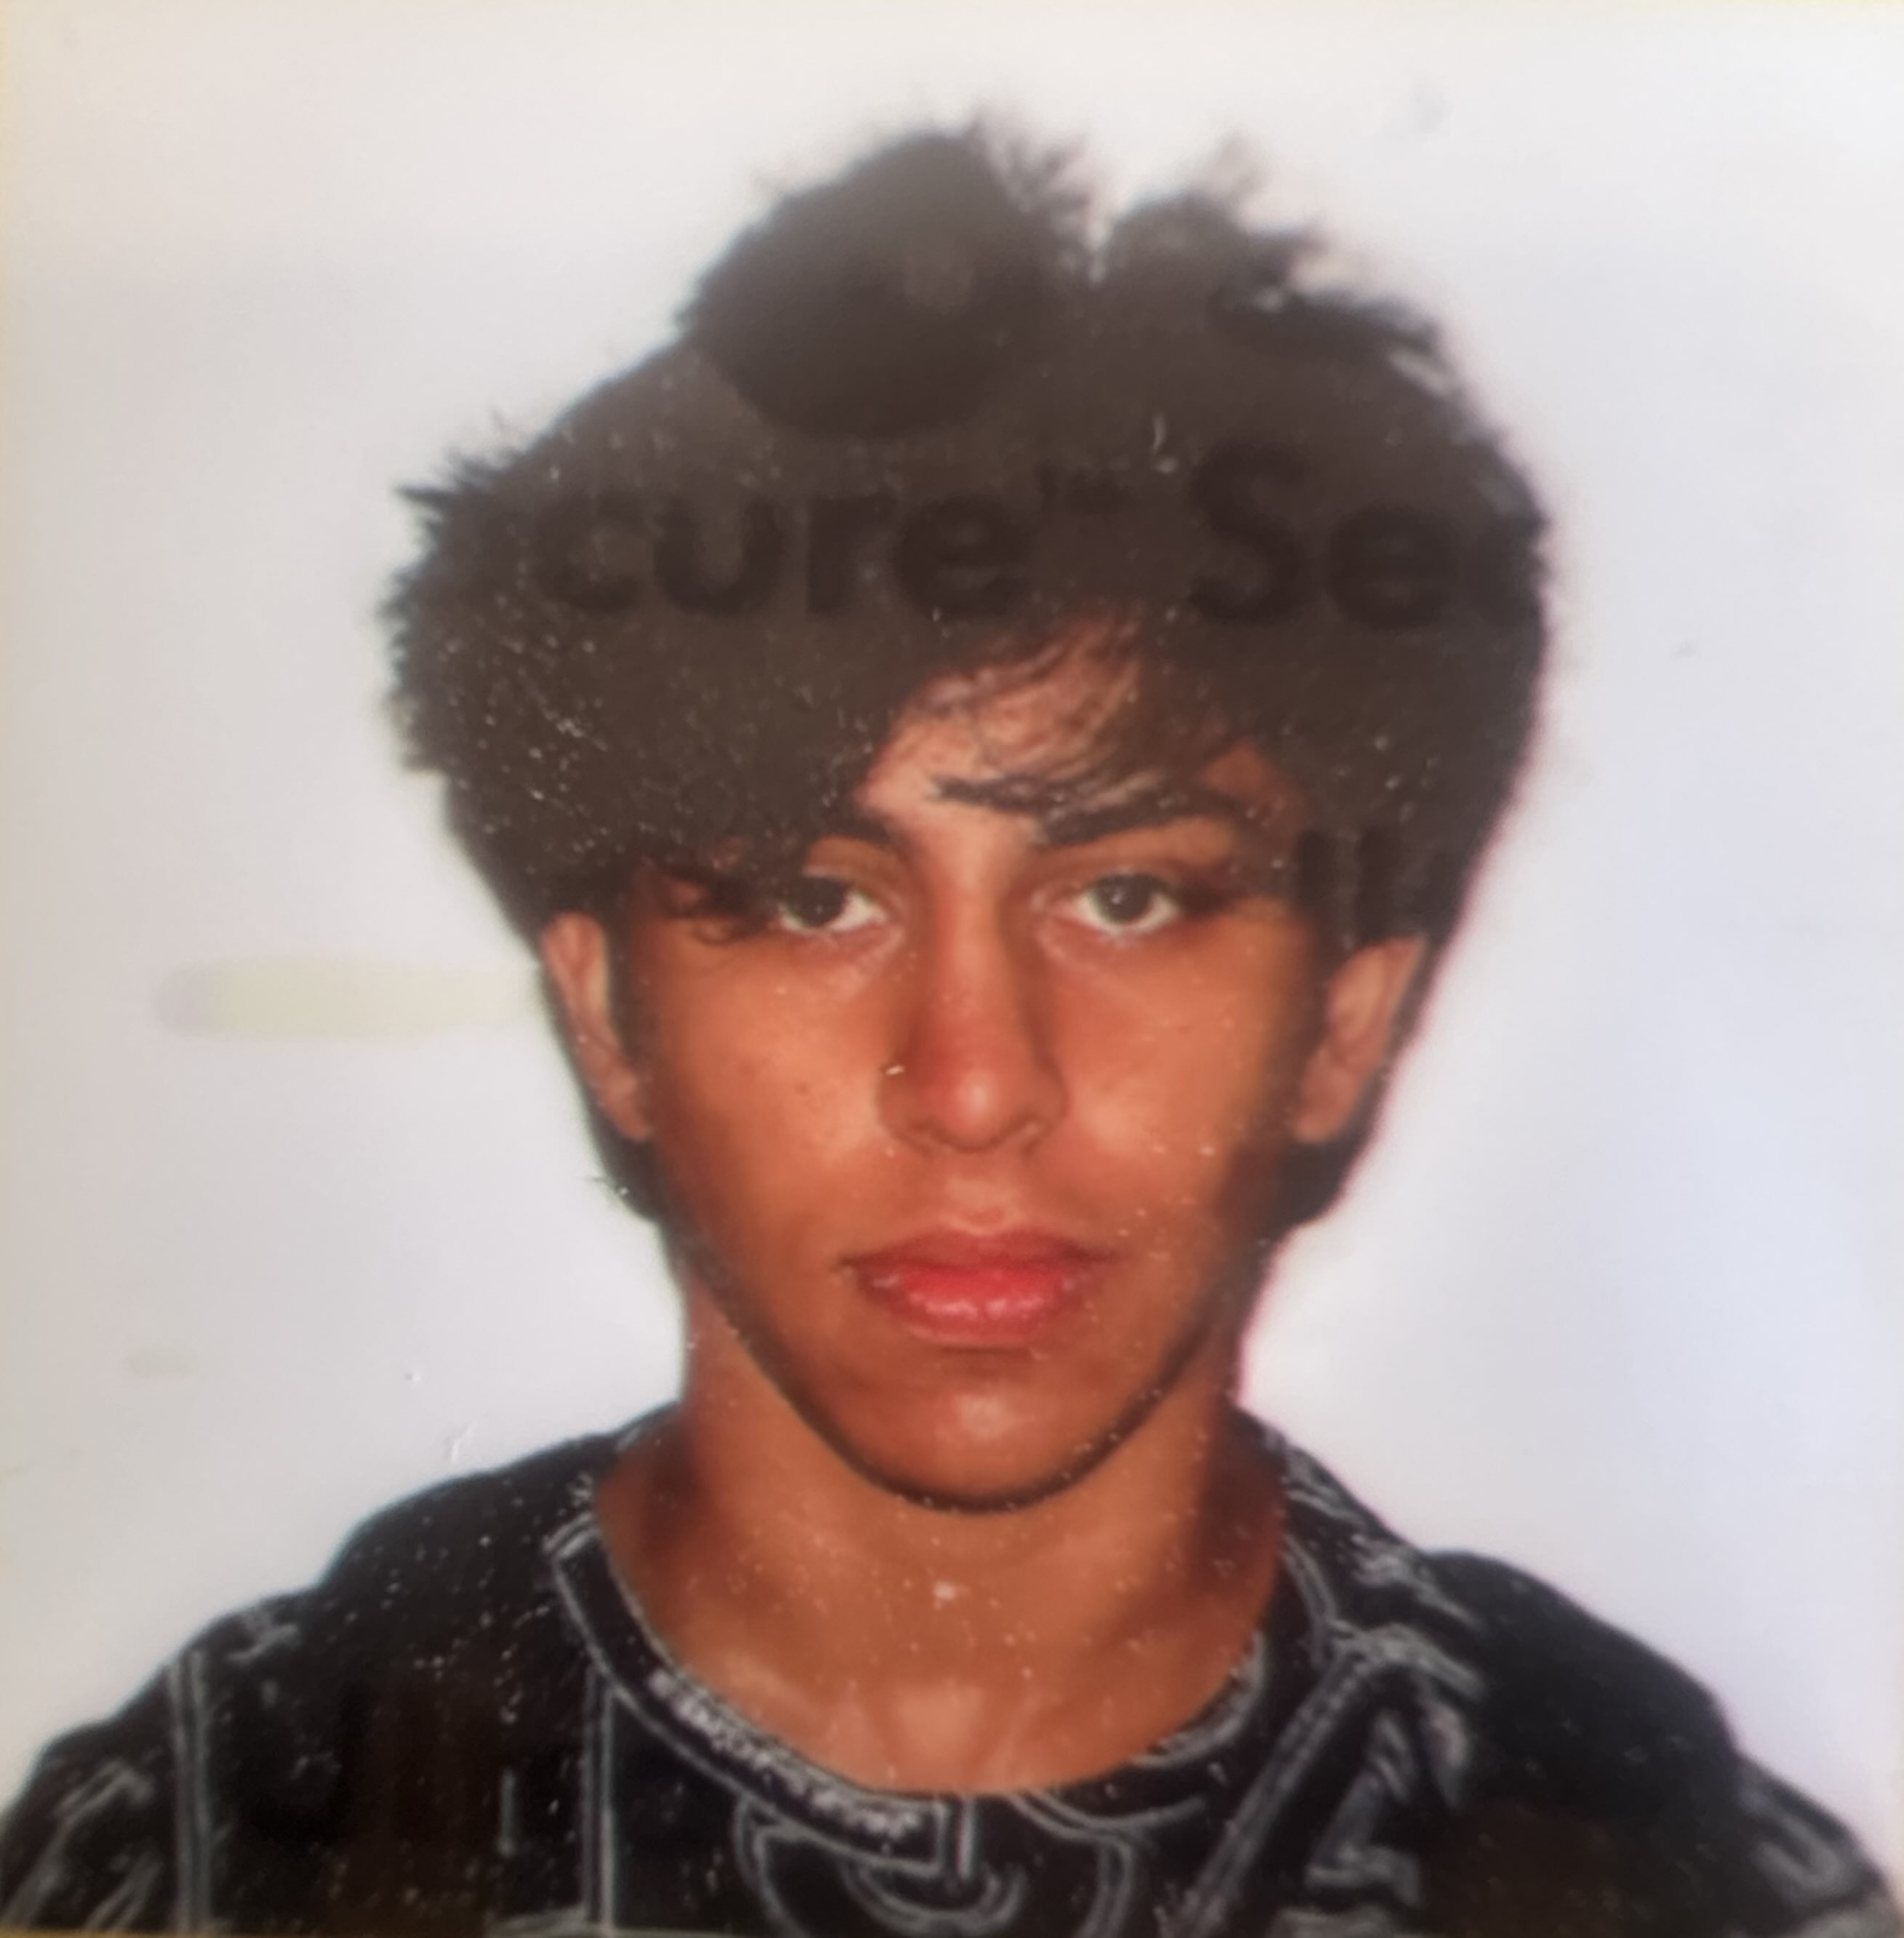

In [241]:
image.show(image)

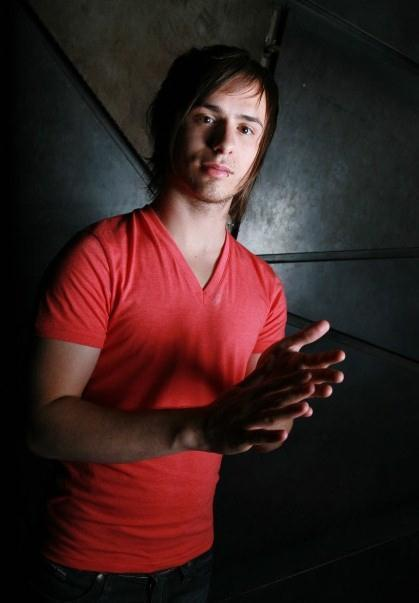

In [240]:
image_tensor = transform(image).unsqueeze(0)
image_tensor = image_tensor.to(next(model.parameters()).device)

with torch.no_grad():
    output = model(image_tensor)


    preds = (output > thresholds).int()
    predictions = preds.squeeze(0).tolist()

    similar = top_k(predictions, 1)['filename'].values[0]
    print
    image_path = os.path.join("/home/skrubstar/datasets/celeba/img_celeba/img_celeba", similar)

    close = Image.open(image_path)
    close.show()